# Tip Prediction Project (Team 02)

# Structure of the Notebook
(1) Load Data <br>
(2) Extend Dataframe by Initial Feature Ideas <br>
(3) Analysing Products-DF Influence on Tipping Behaviour <br>
(4) Correlation Matrix to check Relevancy of Features <br>
> Task 4d) Ranking of Features (Detailed)

(5) Main Task A: Train Classification Model <br>
> Task 4a) Prediction of Accuracy

(6) Main Task B: Probability Prediction of Tips (incl. Log-Loss) <br>
> Task 4b) Prediction of Log-Loss 

(7) Preparation of Final Submission (.csv-files - includes a dataframe with all features used for prediction and predicted values built on top of existing DFs) <br>

(8) Summary: 
> Task 4c) Used Features

> Task 4d) Ranking of Features

> Task 4e) Non-Used Features

> Task 4f) Type of Model

> Task 4g) Hyperparameter Values

# (0) Initialization

In [2]:
#%pip install seaborn pandas numpy matplotlib scikit-learn holidays

Python 3.12.7


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import calendar

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, log_loss
from sklearn.preprocessing import OneHotEncoder

***

# (1) Load Data

In [3]:
# CSV-Dateien: direkt begrenzen´
order_products = pd.read_csv('order_products.csv.zip')
products = pd.read_csv('products.csv.zip')
departments = pd.read_csv('departments.csv.zip')
aisles = pd.read_csv('aisles.csv.zip')
tips = pd.read_csv('tip25_trainingdata.csv.zip')
#tips = tips.dropna(inplace=True) #Drop NaN-Values ERST SPÄTER da wir die zugehörigen Orders dann auch droppen

***

# (2) Extend Orders Dataframe by Initial Feature Ideas

## Liste aller erstellter Features:
- **order_date**: Datum der Bestellung
- **weekday**: Wochentag der Bestellung
- **hour**: Stunde der Bestellung
- **month**: Monat der Bestellung
- **week-start**: Start der Woche, in der die Bestellung ist
- **is_weekend**: binäre Variable (int), um zur Klassifizierung des Wochenendes 
- **nr_previous_orders**: kumulierte Summe der vorigen Bestellungen eines Users
- **days_since_last_order**: Tage seit letzter Bestellung des Users (erster Wert = 0)
- **month-period**: Start, Mitte oder Ende des Monats klassifiziert (Monat in Drittel aufgeteilt)
- **total_previous_tips**: kumulierte Summe der Tips in den vorigen Bestellungen eines Users
- **tipping_history**: kumulierte durchschnittliche Tip-Häufigkeit eines Users (expanding mean)
- **tip_rate_hour_cum**: kumulierte Tip-Rate je Stunde (Tageszeit)
- **previous_tip**: binäre Variable, ob in vorheriger Bestellung getippt wurde
- **pre_previous_tip**: binäre Variable, ob in vor-voriger Bestellung getippt wurde
- **has_selected_aisle**: binäre Variable, ob bestimmte aisles in der Bestellung enthalten sind (Aisles 62, 134, 28, 124, 27)

<br>

## 2.1) Erstellung der Features und Test des Einflusses auf die Tip-Variable

In [4]:
orders = pd.read_parquet('orders.parquet')

# Make sure 'order_date' is datetime
orders['order_date'] = pd.to_datetime(orders['order_date'])

# Add weekday name
orders['weekday'] = orders['order_date'].dt.day_name()

# Add hour 
orders["hour"] = orders["order_date"].dt.hour

#Add week
orders["week-start"] = orders["order_date"].dt.to_period("W").dt.start_time
# Flag weekends: Saturday or Sunday
orders['is_weekend'] = orders['weekday'].isin(['Saturday', 'Sunday']).astype(int)

#Add number of previous orders per user
orders = orders.sort_values(["user_id","order_date"])
orders["nr_previous_orders"] = orders.groupby("user_id").cumcount()

#Add days since last order per user
orders["days_since_last_order"] = orders.groupby("user_id")["order_date"].diff().dt.days
orders["days_since_last_order"] = orders["days_since_last_order"].fillna(0).astype(int) #erste Bestellung mit 0 Tagen

#Add month start/middle/end classification
def month_classification(order_date):
    year = order_date.year
    month = order_date.month
    day = order_date.day
    nr_days_month = calendar.monthrange(year, month)[1]
    first_third = nr_days_month // 3
    middle_third = 2 * nr_days_month // 3
    if day <= first_third:
        return "Start"
    elif day <= middle_third:
        return "Middle"
    else:
        return "End"
    
orders["month-period"] = orders["order_date"].dt.date.apply(month_classification)
orders.head(10)

,order_id,user_id,order_date,weekday,hour,week-start,is_weekend,nr_previous_orders,days_since_last_order,month-period
0,1374495,3,2024-03-31 14:05:18,Sunday,14,2024-03-25,1,0,0,End
1,444309,3,2024-04-09 19:45:51,Tuesday,19,2024-04-08,0,1,9,Start
2,3002854,3,2024-04-30 16:25:20,Tuesday,16,2024-04-29,0,2,20,End
3,2037211,3,2024-05-20 18:31:28,Monday,18,2024-05-20,0,3,20,Middle
4,2710558,3,2024-06-01 17:52:27,Saturday,17,2024-05-27,1,4,11,Start
5,1972919,3,2024-06-08 16:55:12,Saturday,16,2024-06-03,1,5,6,Start
6,1839752,3,2024-06-15 15:04:06,Saturday,15,2024-06-10,1,6,6,Middle
7,3225766,3,2024-06-22 17:49:38,Saturday,17,2024-06-17,1,7,7,End
8,3160850,3,2024-06-29 16:49:34,Saturday,16,2024-06-24,1,8,6,End
9,676467,3,2024-07-16 16:27:44,Tuesday,16,2024-07-15,0,9,16,Middle


In [5]:
# Merge Orders & Tips 
# Drop last Order per user where tip is NaN
orders_and_tips = pd.merge(orders, tips, on="order_id", how="left") 
orders_and_tips = orders_and_tips[orders_and_tips["tip"].notna()] #drop last order per user where tip is NaN
orders_and_tips.head(10)

,order_id,user_id,order_date,weekday,hour,week-start,is_weekend,nr_previous_orders,days_since_last_order,month-period,Unnamed: 0,tip
0,1374495,3,2024-03-31 14:05:18,Sunday,14,2024-03-25,1,0,0,End,0.0,True
1,444309,3,2024-04-09 19:45:51,Tuesday,19,2024-04-08,0,1,9,Start,1.0,False
2,3002854,3,2024-04-30 16:25:20,Tuesday,16,2024-04-29,0,2,20,End,2.0,False
3,2037211,3,2024-05-20 18:31:28,Monday,18,2024-05-20,0,3,20,Middle,3.0,False
4,2710558,3,2024-06-01 17:52:27,Saturday,17,2024-05-27,1,4,11,Start,4.0,True
5,1972919,3,2024-06-08 16:55:12,Saturday,16,2024-06-03,1,5,6,Start,5.0,True
6,1839752,3,2024-06-15 15:04:06,Saturday,15,2024-06-10,1,6,6,Middle,6.0,False
7,3225766,3,2024-06-22 17:49:38,Saturday,17,2024-06-17,1,7,7,End,7.0,False
8,3160850,3,2024-06-29 16:49:34,Saturday,16,2024-06-24,1,8,6,End,8.0,False
9,676467,3,2024-07-16 16:27:44,Tuesday,16,2024-07-15,0,9,16,Middle,9.0,False


## 2.2) Erstellen der Variable has_selected_aisle (Details s. Kapitel (3))

In [6]:
# Liste der relevanten aisle_ids 
# (s. Kapitel (3) Analysing Products-DF Influence on Tipping Behaviour für Details der Aisles und ihrer Auswahl))
selected_aisles = [62, 134, 28, 124, 27]

# Merge: Verbinde order_products mit products, um die aisle_id zu bekommen
order_products_with_aisles = pd.merge(order_products, products[['product_id', 'aisle_id']], on='product_id', how='left')

# Markiere relevante Aisles
order_products_with_aisles['is_selected_aisle'] = order_products_with_aisles['aisle_id'].isin(selected_aisles).astype(int)

# Aggregiere auf Bestellungsebene: hat die Bestellung mind. ein Produkt in diesen aisles?
has_selected_aisle = (
    order_products_with_aisles
    .groupby('order_id')['is_selected_aisle']
    .max()
    .reset_index()
    .rename(columns={'is_selected_aisle': 'has_selected_aisle'})
)

# Jetzt: Füge nur die berechnete Variable hinzu
orders_and_tips = pd.merge(orders_and_tips, has_selected_aisle, on="order_id", how="left")

# Fehlende Werte (z. B. bei Bestellungen ohne Produkte) mit 0 auffüllen
orders_and_tips['has_selected_aisle'] = orders_and_tips['has_selected_aisle'].fillna(0).astype(int)

orders_and_tips.head()

,order_id,user_id,order_date,weekday,hour,week-start,is_weekend,nr_previous_orders,days_since_last_order,month-period,Unnamed: 0,tip,has_selected_aisle
0,1374495,3,2024-03-31 14:05:18,Sunday,14,2024-03-25,1,0,0,End,0.0,True,0
1,444309,3,2024-04-09 19:45:51,Tuesday,19,2024-04-08,0,1,9,Start,1.0,False,0
2,3002854,3,2024-04-30 16:25:20,Tuesday,16,2024-04-29,0,2,20,End,2.0,False,0
3,2037211,3,2024-05-20 18:31:28,Monday,18,2024-05-20,0,3,20,Middle,3.0,False,0
4,2710558,3,2024-06-01 17:52:27,Saturday,17,2024-05-27,1,4,11,Start,4.0,True,0


## 2.3) Analyse von General Order Features auf Tipping Behaviour

## 2.3.1) Analyse Wochentag & Wochenende

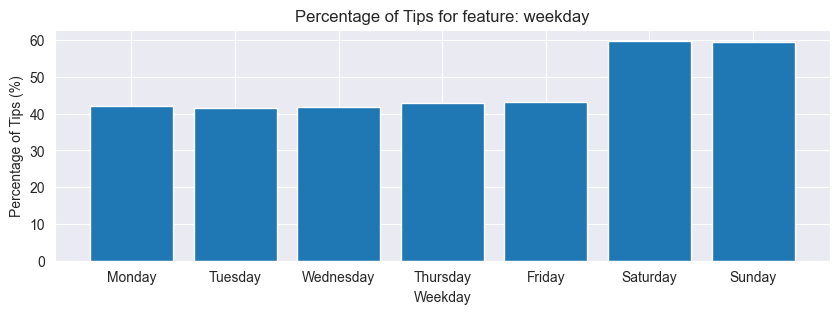

Höchste Tip-Wkeiten
                 tip
weekday             
Saturday   59.832629
Sunday     59.406033
Friday     43.207775
Thursday    42.99998
Monday     42.083245
Wednesday  41.904066
Tuesday    41.441993


In [7]:
### Testing weekday influence
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
tip_by_testfeature = orders_and_tips[["weekday","tip"]].groupby("weekday").mean()*100
tip_by_testfeature = tip_by_testfeature.reindex(weekday_order)
plt.figure(figsize=(10, 3))
plt.bar(tip_by_testfeature.index, tip_by_testfeature["tip"])
plt.xlabel('Weekday')
plt.ylabel('Percentage of Tips (%)')
plt.title('Percentage of Tips for feature: weekday')
plt.show()
print("Höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

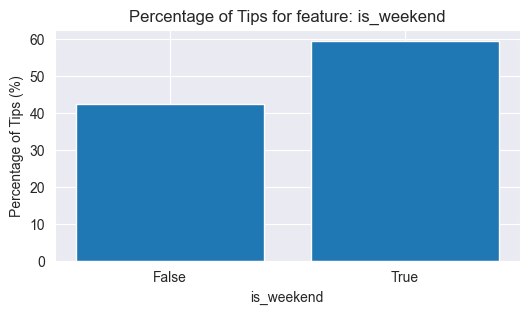

Korrelation:  0.1634585571320028
Höchste Tip-Wkeiten
                  tip
is_weekend           
1           59.609686
0           42.328774


In [8]:
### Testing is_weekend influence
tip_by_testfeature = orders_and_tips[["is_weekend","tip"]].groupby("is_weekend").mean()*100
plt.figure(figsize=(6, 3))
plt.bar(tip_by_testfeature.index, tip_by_testfeature["tip"])
plt.xlabel('is_weekend')
plt.ylabel('Percentage of Tips (%)')
plt.xticks([0,1], ['False', 'True'], rotation=0)
plt.title('Percentage of Tips for feature: is_weekend')
plt.show()
corr_matrix = orders_and_tips["is_weekend"].corr(orders_and_tips["tip"])
print("Korrelation: ", corr_matrix)
print("Höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

#### Wochenende hat einen Einfluss! (weekday und is_weekend zeigen den gleichen Effekt in unterschiedlichen Granularitäten)

## 2.3.2) Einfluss der Stunden

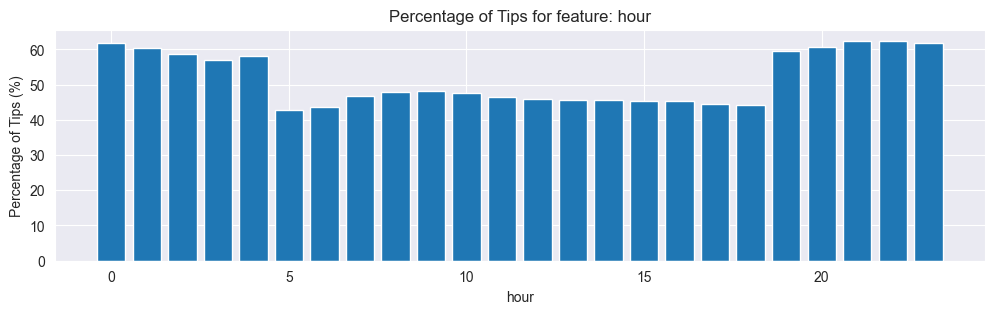

Korrelation:  0.03617046887262718
Höchste Tip-Wkeiten
            tip
hour           
22    62.448434
21    62.304509
23    61.817165
0     61.731813
20    60.537998
1     60.248578
19    59.416679
2     58.789723
4     58.223395
3     56.969697


In [9]:
### Testing hour influence
tip_by_testfeature = orders_and_tips[["hour","tip"]].groupby("hour").mean()*100
plt.figure(figsize=(12, 3))
plt.bar(tip_by_testfeature.index, tip_by_testfeature["tip"])
plt.xlabel('hour')
plt.ylabel('Percentage of Tips (%)')
plt.title('Percentage of Tips for feature: hour')
plt.show()
corr_matrix = orders_and_tips["hour"].corr(orders_and_tips["tip"])
print("Korrelation: ", corr_matrix)
print("Höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

#### Tageszeit der Bestellung hat einen Einfluss

## 2.3.3) Einfluss des Zeitverlaufes (Wochenübersicht des Datensatzes)

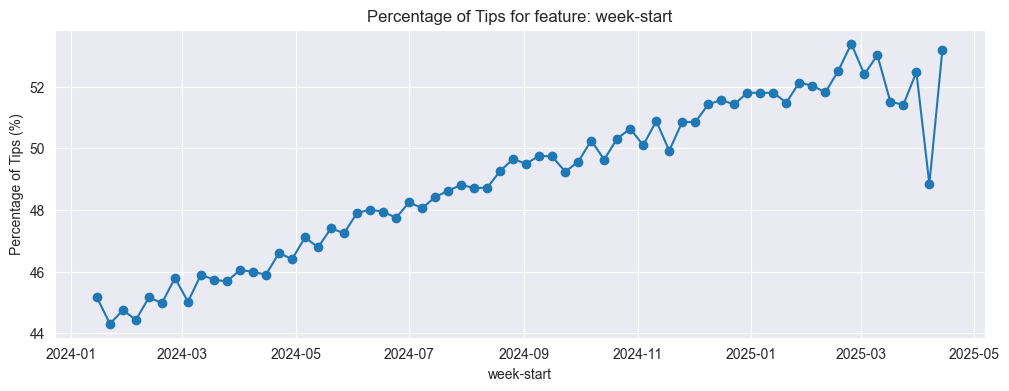

Höchste Tip-Wkeiten
                  tip
week-start           
2025-02-24   53.38822
2025-04-14  53.191489
2025-03-10  53.017985
2025-02-17  52.510858
2025-03-31  52.468619
2025-03-03  52.393928
2025-01-27  52.130682
2025-02-03  52.026821
2025-02-10  51.810748
2024-12-30  51.801655


In [10]:
### Testing week-start influence
tip_by_testfeature = orders_and_tips[["week-start","tip"]].groupby("week-start").mean()*100
plt.figure(figsize=(12, 4))
plt.plot(tip_by_testfeature.index, tip_by_testfeature["tip"], marker="o")
plt.xlabel('week-start')
plt.ylabel('Percentage of Tips (%)')
plt.title('Percentage of Tips for feature: week-start')
plt.show()
print("Höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

#### Tip Wahrscheinlichkeit nimmt mit der Zeit zu
#### Achtung bzgl. Ende: starke Schwankungen durch wenige Bestellungen im Endbereich des Features 

## 2.3.4) Einfluss der Anzahl der vorigen Bestellungen

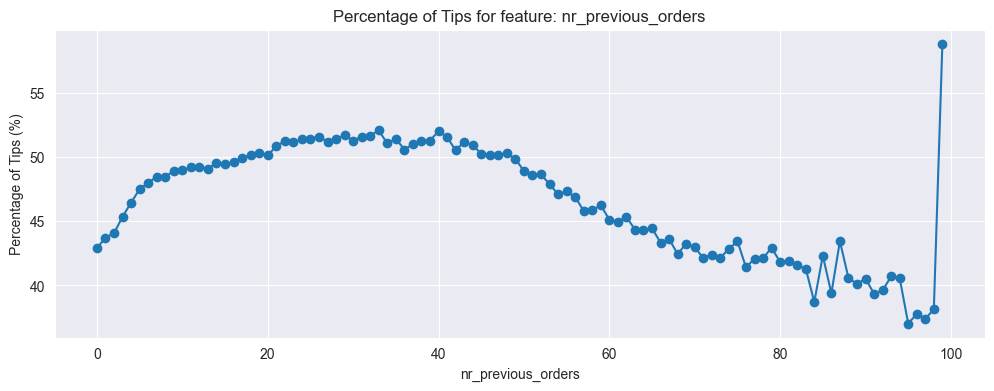

Korrelation:  -0.002178290061804034
Höchste Tip-Wkeiten
                          tip
nr_previous_orders           
99                  58.823529
33                  52.061307
40                  51.999059
29                   51.73646
32                  51.666059
26                  51.590088
31                  51.580069
41                  51.558558
25                   51.42513
35                  51.408264


In [11]:
### Testing nr_previous_orders influence
tip_by_testfeature = orders_and_tips[["nr_previous_orders","tip"]].groupby("nr_previous_orders").mean()*100
plt.figure(figsize=(12, 4))
plt.plot(tip_by_testfeature.index, tip_by_testfeature["tip"], marker="o")
plt.xlabel('nr_previous_orders')
plt.ylabel('Percentage of Tips (%)')
plt.title('Percentage of Tips for feature: nr_previous_orders')
plt.show()
corr_matrix = orders_and_tips["nr_previous_orders"].corr(orders_and_tips["tip"])
print("Korrelation: ", corr_matrix)
print("Höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

#### Tip Wahrscheinlichkeit nimmt bis zu ~20 Bestellungen eines Users zu, dort erreicht sie ein Plateau bis ~40 und sinkt danach wieder. Korrelation negativ.
#### Ende: starke Schwankungen durch wenige Bestellungen im Endbereich des Features 

## 2.3.5) Einfluss der Tage seit der letzten Bestellung

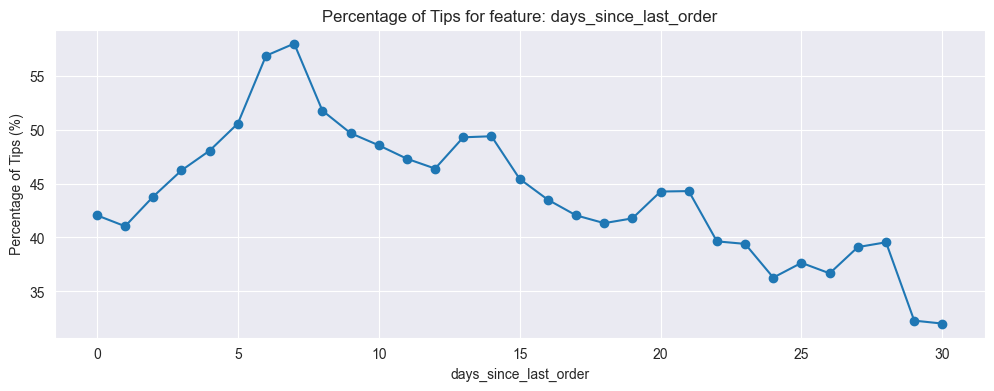

Korrelation:  0.0031307832490313024
Höchste Tip-Wkeiten
                             tip
days_since_last_order           
7                      58.005665
6                      56.877375
8                      51.780681
5                      50.578879
9                      49.684993
14                     49.397636
13                      49.29972
10                     48.555957
4                      48.061941
11                     47.307665


In [12]:
### Testing days_since_last_order influence
tip_by_testfeature = orders_and_tips[["days_since_last_order","tip"]].groupby("days_since_last_order").mean()*100
plt.figure(figsize=(12, 4))
plt.plot(tip_by_testfeature.index, tip_by_testfeature["tip"], marker="o")
plt.xlabel('days_since_last_order')
plt.ylabel('Percentage of Tips (%)')
plt.title('Percentage of Tips for feature: days_since_last_order')
plt.show()
corr_matrix = orders_and_tips["days_since_last_order"].corr(orders_and_tips["tip"])
print("Korrelation: ", corr_matrix)
print("Höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

#### Die Tip Wahrscheinlichkeit nimmt mit größer werdendem Abstand zur letzten Bestellung ab der 7ten Bestellung ab. Bis dahin steigt sie.

## 2.3.6) Einfluss der Zeit im Monat

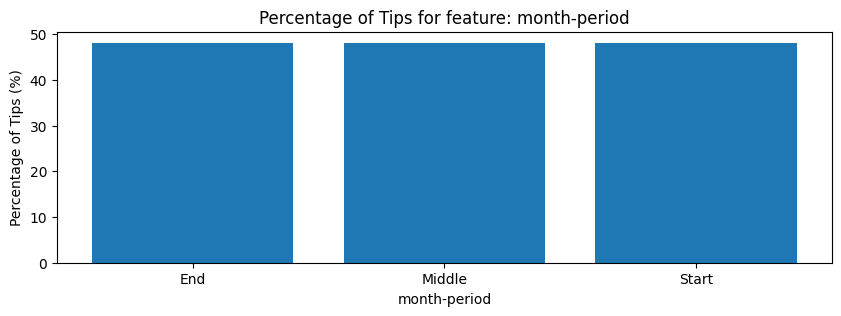

Höchste Tip-Wkeiten
                    tip
month-period           
End           48.165664
Start          48.16009
Middle        48.121088


In [12]:
### Testing month-period influence
tip_by_testfeature = orders_and_tips[["month-period","tip"]].groupby("month-period").mean()*100
plt.figure(figsize=(10, 3))
plt.bar(tip_by_testfeature.index, tip_by_testfeature["tip"])
plt.xlabel('month-period')
plt.ylabel('Percentage of Tips (%)')
plt.title('Percentage of Tips for feature: month-period')
plt.show()
print("Höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

#### Der monatliche Zeitpunkt Beginn/Mitte/Ende des Monats hat keinen Einflus auf die Tip-Wahrscheinlichkeit

## 2.3.7) Einfluss der Tipping History eines Users

In [7]:
#Testing User Tip-Rate (Tipping_History)
#Making sure it´s sorted again
orders_and_tips = orders_and_tips.sort_values(["user_id","order_date"])
orders_and_tips["tipping_history"] = orders_and_tips.groupby("user_id")["tip"].apply(lambda x: x.shift().expanding().mean()).reset_index(level=0, drop=True)
orders_and_tips.head(20)

,order_id,user_id,order_date,weekday,hour,week-start,is_weekend,nr_previous_orders,days_since_last_order,month-period,Unnamed: 0,tip,has_selected_aisle,tipping_history
0,1374495,3,2024-03-31 14:05:18,Sunday,14,2024-03-25,1,0,0,End,0.0,True,0,NaN
1,444309,3,2024-04-09 19:45:51,Tuesday,19,2024-04-08,0,1,9,Start,1.0,False,0,1.000000
2,3002854,3,2024-04-30 16:25:20,Tuesday,16,2024-04-29,0,2,20,End,2.0,False,0,0.500000
3,2037211,3,2024-05-20 18:31:28,Monday,18,2024-05-20,0,3,20,Middle,3.0,False,0,0.333333
4,2710558,3,2024-06-01 17:52:27,Saturday,17,2024-05-27,1,4,11,Start,4.0,True,0,0.250000
5,1972919,3,2024-06-08 16:55:12,Saturday,16,2024-06-03,1,5,6,Start,5.0,True,0,0.400000
6,1839752,3,2024-06-15 15:04:06,Saturday,15,2024-06-10,1,6,6,Middle,6.0,False,0,0.500000
7,3225766,3,2024-06-22 17:49:38,Saturday,17,2024-06-17,1,7,7,End,7.0,False,0,0.428571
8,3160850,3,2024-06-29 16:49:34,Saturday,16,2024-06-24,1,8,6,End,8.0,False,0,0.375000
9,676467,3,2024-07-16 16:27:44,Tuesday,16,2024-07-15,0,9,16,Middle,9.0,False,0,0.333333


In [14]:
corr_matrix = orders_and_tips["tipping_history"].corr(orders_and_tips["tip"])
print("Korrelation: ", corr_matrix)

Korrelation:  0.5303929818180738


### Die Tip-Rate in den vorherigen Bestellungen hat eine hohe Korrelation mit den Tips.

## 2.3.8) Einfluss des Monats

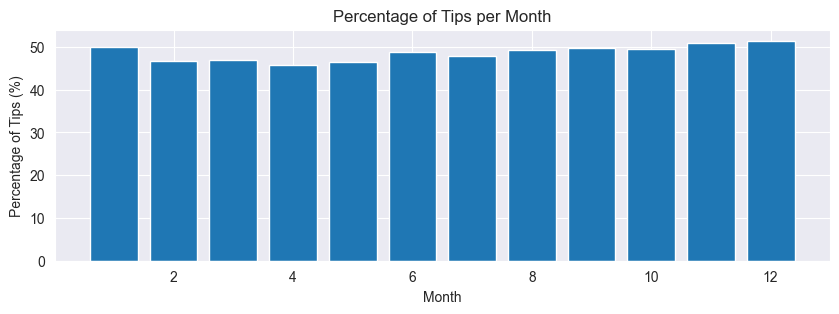

In [8]:
# Add Month
orders_and_tips['month'] = orders_and_tips['order_date'].dt.month


# Effekt des Monats
tip_by_testfeature = orders_and_tips[["month", "tip"]].groupby("month").mean() * 100
plt.figure(figsize=(10,3))
plt.bar(tip_by_testfeature.index, tip_by_testfeature["tip"])
plt.xlabel("Month")
plt.ylabel("Percentage of Tips (%)")
plt.title("Percentage of Tips per Month")
plt.show()

### Kein bzw. kaum Einfluss des Monats auf die Tip-Wahrscheinlichkeit

## 2.3.9) Einfluss der Anzahl vorheriger Tips eines Users

In [9]:
orders_and_tips = orders_and_tips.sort_values(["user_id", "order_date"])

# Anzahl vorheriger Tips
orders_and_tips['tip'] = orders_and_tips['tip'].astype(bool) 
orders_and_tips["total_previous_tips"] = orders_and_tips.groupby("user_id")["tip"].cumsum() - orders_and_tips["tip"] # Tip abziehen, da cumsum kumulative Summe inklusiver aktueller Zeile ist, aber diese Information in Zelle nicht vorliegt (Zeitreihe)

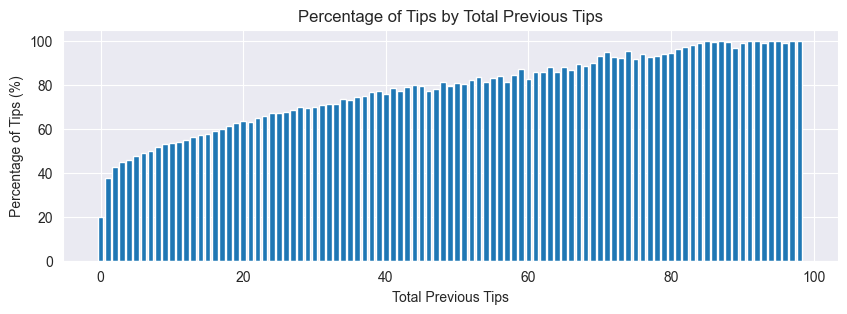

In [15]:
# Effekt des Monats
tip_by_testfeature = orders_and_tips[["total_previous_tips", "tip"]].groupby("total_previous_tips").mean() * 100
plt.figure(figsize=(10,3))
plt.bar(tip_by_testfeature.index, tip_by_testfeature["tip"])
plt.xlabel("Total Previous Tips")
plt.ylabel("Percentage of Tips (%)")
plt.title("Percentage of Tips by Total Previous Tips")
plt.show()

#### Effekt besteht für Total Previous Tips 

## 2.3.10) Boolean: Tip in voriger und vor-voriger Bestellung

In [10]:
#Previous und Pre-Previous Tips als Features erstellt
orders_and_tips = orders_and_tips.sort_values(['user_id', 'order_date'])

orders_and_tips['previous_tip'] = orders_and_tips.groupby("user_id")['tip'].shift(1)
orders_and_tips['pre_previous_tip'] = orders_and_tips.groupby("user_id")['tip'].shift(2)

In [11]:
# Erstellen von kumulativer Tip-Rate je Stunde
# Sortiere nach Zeit, falls noch nicht geschehen
orders_and_tips = orders_and_tips.sort_values("order_date")

# Berechne kumulative Tipp-Rate je Stunde (ohne Leakage)
orders_and_tips['tip_rate_hour_cum'] = (
    orders_and_tips
    .groupby('hour')['tip']
    .transform(lambda x: x.shift().expanding().mean())
)

# Optional: Ersetze NaNs durch globalen Tipp-Mittelwert
global_tip_mean = orders_and_tips['tip'].mean()
orders_and_tips['tip_rate_hour_cum'] = orders_and_tips['tip_rate_hour_cum'].fillna(global_tip_mean)

In [12]:
# Übersicht über aktuelles DataFrame
orders_and_tips.head(10)

,order_id,user_id,order_date,weekday,hour,week-start,is_weekend,nr_previous_orders,days_since_last_order,month-period,Unnamed: 0,tip,has_selected_aisle,tipping_history,month,total_previous_tips,previous_tip,pre_previous_tip,tip_rate_hour_cum
595901,1510472,87063,2024-01-17 00:17:26,Wednesday,0,2024-01-15,0,0,0,Middle,622282.0,True,0,NaN,1,0,NaN,NaN,0.481493
157592,2707022,22717,2024-01-17 00:24:45,Wednesday,0,2024-01-15,0,0,0,Middle,164612.0,False,0,NaN,1,0,NaN,NaN,1.000000
858837,1789128,125953,2024-01-17 06:42:03,Wednesday,6,2024-01-15,0,0,0,Middle,896772.0,False,0,NaN,1,0,NaN,NaN,0.481493
391638,2345092,57110,2024-01-17 08:08:49,Wednesday,8,2024-01-15,0,0,0,Middle,408959.0,False,0,NaN,1,0,NaN,NaN,0.481493
1289501,2262337,189818,2024-01-17 08:12:16,Wednesday,8,2024-01-15,0,0,0,Middle,1346660.0,False,0,NaN,1,0,NaN,NaN,0.000000
609278,501461,89021,2024-01-17 08:14:05,Wednesday,8,2024-01-15,0,0,0,Middle,636230.0,True,1,NaN,1,0,NaN,NaN,0.000000
673935,3251724,98368,2024-01-17 08:35:56,Wednesday,8,2024-01-15,0,0,0,Middle,703679.0,True,0,NaN,1,0,NaN,NaN,0.333333
1198270,1122415,176543,2024-01-17 08:45:30,Wednesday,8,2024-01-15,0,0,0,Middle,1251452.0,False,0,NaN,1,0,NaN,NaN,0.500000
47508,411552,6891,2024-01-17 09:08:57,Wednesday,9,2024-01-15,0,0,0,Middle,49626.0,True,0,NaN,1,0,NaN,NaN,0.481493
680718,2462518,99335,2024-01-17 09:16:51,Wednesday,9,2024-01-15,0,0,0,Middle,710763.0,False,0,NaN,1,0,NaN,NaN,1.000000


## <u> Subsection: Einfluss der Anzahl Produkte je Bestellung </u>

"orders_with_counts"-DF zur Analyse der Anzahl Produkte je Bestellung
- product_count: Anzahl Bestellungen in einer Order

In [22]:
# Testing number of products per order
product_counts = order_products.groupby("order_id").size().reset_index(name="product_count")
product_counts.head()
orders_with_counts = orders_and_tips.merge(product_counts, on="order_id", how="left")
orders_with_counts.head()

,order_id,user_id,order_date,weekday,hour,week-start,is_weekend,nr_previous_orders,days_since_last_order,month-period,Unnamed: 0,tip,has_selected_aisle,tipping_history,month,total_previous_tips,previous_tip,pre_previous_tip,tip_rate_hour_cum,product_count
0,1510472,87063,2024-01-17 00:17:26,Wednesday,0,2024-01-15,0,0,0,Middle,622282.0,True,0,NaN,1,0,NaN,NaN,0.481493,16
1,2707022,22717,2024-01-17 00:24:45,Wednesday,0,2024-01-15,0,0,0,Middle,164612.0,False,0,NaN,1,0,NaN,NaN,1.000000,26
2,1789128,125953,2024-01-17 06:42:03,Wednesday,6,2024-01-15,0,0,0,Middle,896772.0,False,0,NaN,1,0,NaN,NaN,0.481493,12
3,2345092,57110,2024-01-17 08:08:49,Wednesday,8,2024-01-15,0,0,0,Middle,408959.0,False,0,NaN,1,0,NaN,NaN,0.481493,1
4,2262337,189818,2024-01-17 08:12:16,Wednesday,8,2024-01-15,0,0,0,Middle,1346660.0,False,0,NaN,1,0,NaN,NaN,0.000000,5


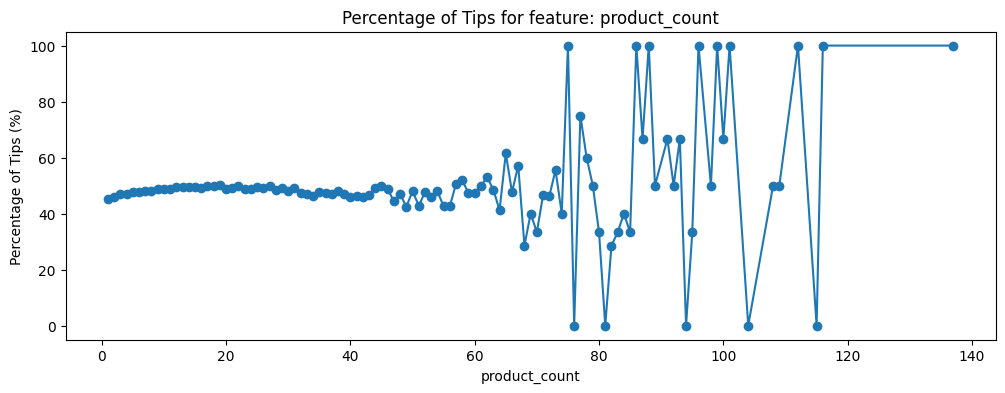

Korrelation:  0.014834426661620605
Höchste Tip-Wkeiten
                 tip
product_count       
137            100.0
101            100.0
96             100.0
88             100.0
86             100.0
75             100.0
112            100.0
116            100.0
99             100.0
77              75.0


In [23]:
### Testing product_counts influence
tip_by_testfeature = orders_with_counts[["product_count","tip"]].groupby("product_count").mean()*100
plt.figure(figsize=(12, 4))
plt.plot(tip_by_testfeature.index, tip_by_testfeature["tip"], marker="o")
plt.xlabel('product_count')
plt.ylabel('Percentage of Tips (%)')
plt.title('Percentage of Tips for feature: product_count')
plt.show()
corr_matrix = orders_with_counts["product_count"].corr(orders_with_counts["tip"])
print("Korrelation: ", corr_matrix)
print("Höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

#### Kein bis geringer Einfluss auf die Tip-Wahrscheinlichkeit 
#### Ende: nur Einzelbestellungen (0% oder 100%) bzw. sehr wenige Bestellungen führen zu extremen Schwankungen bei den Wahrscheinlichkeiten des Product Counts - daher Product Count begrenzt

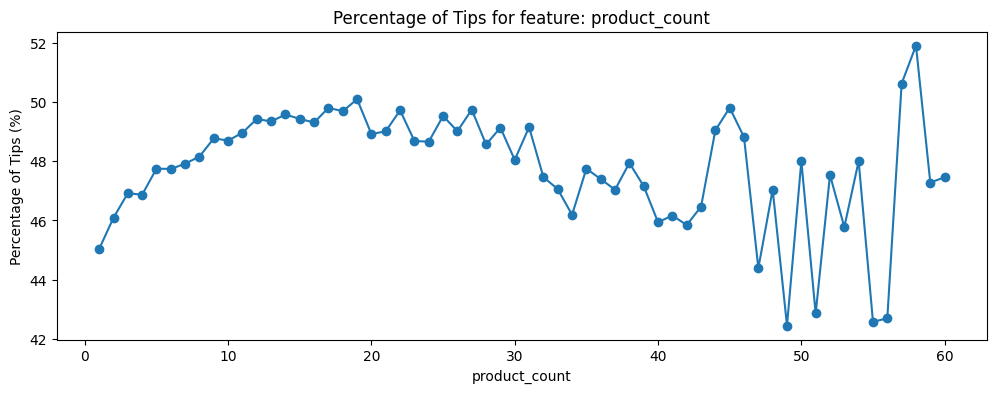

Korrelation:  0.014913054382405588
Höchste Tip-Wkeiten
                     tip
product_count           
58             51.898734
57             50.617284
19             50.089547
45             49.802372
17             49.796373
27             49.736247
22             49.713833
18             49.683922
14             49.574139
25             49.522293


In [24]:
# Extremfälle ignoriert
orders_with_counts = orders_with_counts[orders_with_counts["product_count"]<=60]
### Testing product_counts influence
tip_by_testfeature = orders_with_counts[["product_count","tip"]].groupby("product_count").mean()*100
plt.figure(figsize=(12, 4))
plt.plot(tip_by_testfeature.index, tip_by_testfeature["tip"], marker="o")
plt.xlabel('product_count')
plt.ylabel('Percentage of Tips (%)')
plt.title('Percentage of Tips for feature: product_count')
plt.show()
corr_matrix = orders_with_counts["product_count"].corr(orders_with_counts["tip"])
print("Korrelation: ", corr_matrix)
print("Höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

#### Geringe Schwankungen, jedoch in einem Bereich von ~8 Prozentpunkten 

***

# (3) <u> Analysing Products-DF Influence on Tipping Behaviour </u>
### Merge von order_products, products und orders zur Analyse von aisle_id und department_id bzw. deren Einfluss auf Tipping Behaviour 
### Analyse für die spätere Variable "has_selected_aisle"

Größe der Bestellungen <br>
Regelmäßigkeit der Bestellungen <br>
Welches produkt am meisten tips hat (department = Art des Produkts, aisles = genaue Kategorie)


In [25]:
# Dateien einlesen
order_products = pd.read_csv('order_products.csv.zip')
products = pd.read_csv('products.csv.zip')
departments = pd.read_csv('departments.csv.zip')
aisles = pd.read_csv('aisles.csv.zip')
orders2 = pd.read_parquet('orders.parquet')

In [26]:
# Merge von order_products und products
order_products_details = pd.merge(order_products, products, on="product_id", how="left")
order_products_details = order_products_details.drop(columns="product_name")
order_products_details.head()

,order_id,product_id,add_to_cart_order,aisle_id,department_id
0,1,49302,1,120,16
1,1,11109,2,108,16
2,1,10246,3,83,4
3,1,49683,4,83,4
4,1,43633,5,95,15


In [27]:
# Merge des vorig erstellten Datensatzes mit orders
orders_and_order_products_details = pd.merge(orders2, order_products_details, on="order_id", how="left")
orders_and_order_products_details.head()

,order_id,user_id,order_date,product_id,add_to_cart_order,aisle_id,department_id
0,1374495,3,2024-03-31 14:05:18,9387.0,1.0,24.0,4.0
1,1374495,3,2024-03-31 14:05:18,17668.0,2.0,91.0,16.0
2,1374495,3,2024-03-31 14:05:18,15143.0,3.0,24.0,4.0
3,1374495,3,2024-03-31 14:05:18,16797.0,4.0,24.0,4.0
4,1374495,3,2024-03-31 14:05:18,39190.0,5.0,91.0,16.0


In [28]:
# Merge mit tips zum Testen
orders_details_and_tip = pd.merge(orders_and_order_products_details, tips, on="order_id", how="left")
orders_details_and_tip.head()

,order_id,user_id,order_date,product_id,add_to_cart_order,aisle_id,department_id,Unnamed: 0,tip
0,1374495,3,2024-03-31 14:05:18,9387.0,1.0,24.0,4.0,0.0,True
1,1374495,3,2024-03-31 14:05:18,17668.0,2.0,91.0,16.0,0.0,True
2,1374495,3,2024-03-31 14:05:18,15143.0,3.0,24.0,4.0,0.0,True
3,1374495,3,2024-03-31 14:05:18,16797.0,4.0,24.0,4.0,0.0,True
4,1374495,3,2024-03-31 14:05:18,39190.0,5.0,91.0,16.0,0.0,True


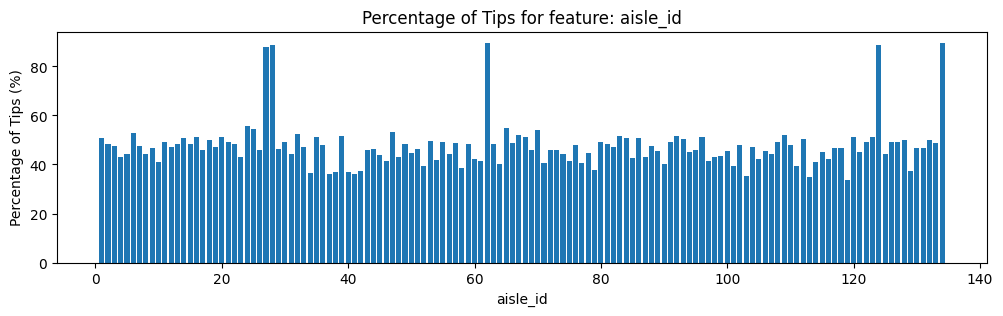

Korrelation:  -0.011921415975361118
10 höchste Tip-Wkeiten
                tip
aisle_id           
62.0      89.683279
134.0     89.441277
28.0      88.634412
124.0     88.630679
27.0       87.85018
24.0      55.715457
65.0       54.93345
25.0      54.343247
70.0      54.240416
47.0        53.0562


In [29]:
### Testing aisle influence
tip_by_testfeature = orders_details_and_tip[["aisle_id","tip"]].groupby("aisle_id").mean()*100
plt.figure(figsize=(12, 3))
plt.bar(tip_by_testfeature.index, tip_by_testfeature["tip"])
plt.xlabel('aisle_id')
plt.ylabel('Percentage of Tips (%)')
plt.title('Percentage of Tips for feature: aisle_id')
plt.show()
corr_matrix = orders_details_and_tip["aisle_id"].corr(orders_details_and_tip["tip"])
print("Korrelation: ", corr_matrix)
print("10 höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

#### Nur wenige Aisles mit einem tatsächlichen Einfluss auf das Tipping-Verhalten 
#### Die aisles mit einer Wahrscheinlichkeit >80% wurden für die Variable "has_selected_aisle" verwendet

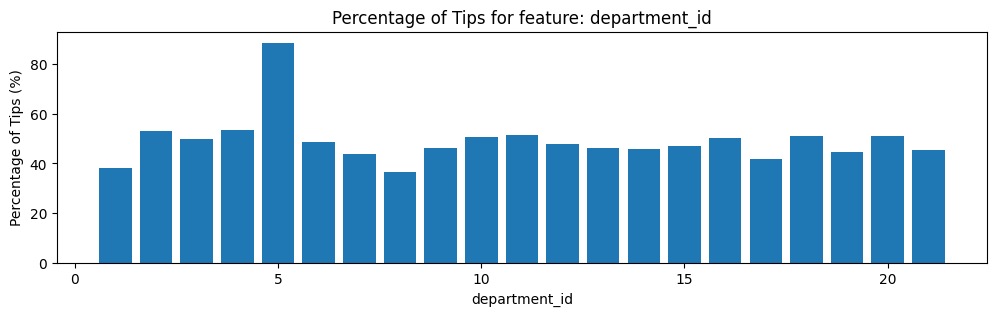

Korrelation:  -0.015029712534102435
10 höchste Tip-Wkeiten
                     tip
department_id           
5.0            88.661639
4.0            53.240985
2.0            52.926518
11.0           51.324899
20.0           51.160257
18.0           51.017835
10.0           50.545943
16.0           50.067001
3.0            49.680503
6.0            48.654744


In [30]:
### Testing department influence
tip_by_testfeature = orders_details_and_tip[["department_id","tip"]].groupby("department_id").mean()*100
plt.figure(figsize=(12, 3))
plt.bar(tip_by_testfeature.index, tip_by_testfeature["tip"])
plt.xlabel('department_id')
plt.ylabel('Percentage of Tips (%)')
plt.title('Percentage of Tips for feature: department_id')
plt.show()
corr_matrix = orders_details_and_tip["department_id"].corr(orders_details_and_tip["tip"])
print("Korrelation: ", corr_matrix)
print("10 höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

#### Einzelnes Department (Alkohol) mit Einfluss auf Tipping Behaviour - die restlichen Departments teilen sich sehr ähnliche Wahrscheinlichkeiten

In [31]:
### Testing product influence
tip_by_testfeature = orders_details_and_tip[["product_id","tip"]].groupby("product_id").mean()*100
# plt.figure(figsize=(12, 3))
# plt.bar(tip_by_testfeature.index, tip_by_testfeature["tip"])
# plt.xlabel('product_id')
# plt.ylabel('Percentage of Tips (%)')
# plt.title('Percentage of Tips for feature: product_id')
# plt.show()
# plot dauert ne gute minute
corr_matrix = orders_details_and_tip["product_id"].corr(orders_details_and_tip["tip"])
print("Korrelation: ", corr_matrix)
print("10 höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

Korrelation:  0.0018724341012811099
10 höchste Tip-Wkeiten
              tip
product_id       
35397.0     100.0
15859.0     100.0
6590.0      100.0
30335.0     100.0
24258.0     100.0
6591.0      100.0
15833.0     100.0
15836.0     100.0
24266.0     100.0
15847.0     100.0



#### Aus diesem Abschnitt wurde einzig die Variable "has_selected_aisle" erstellt und abgeleitet, da hier mehrfach verschiedene Ebenen derselben Erkenntnis ergründet wurden. Es wurde sich für die feingliedrige Variante der Aisles entschieden.
___

# (4) Correlation Matrix to check Relevancy of Features 
## (Task 4d) 

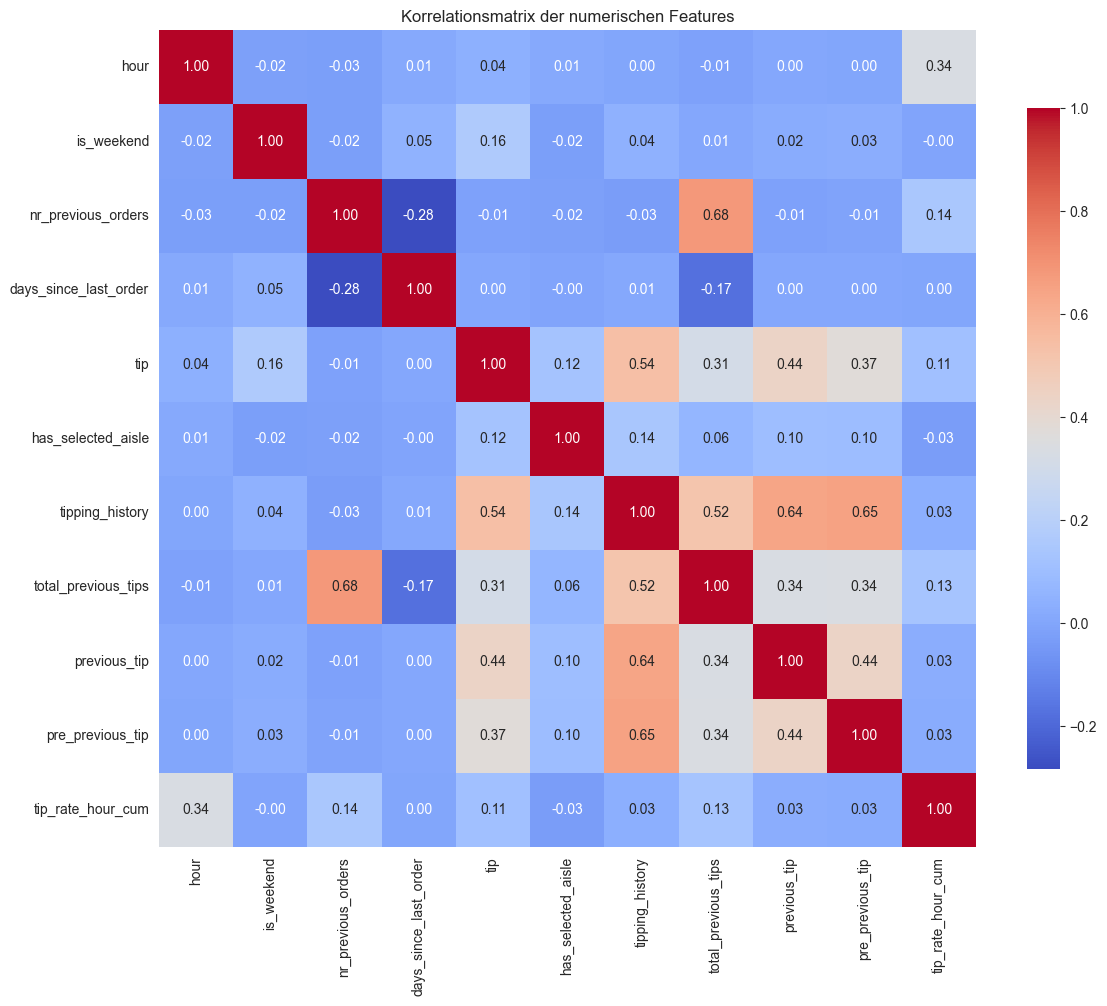

In [19]:
# Entferne unwichtige Spalten:
columns_to_drop = [col for col in ['Unnamed: 0', 'user_id', 'order_id', 'order_date'] if col in orders_and_tips.columns]
df_corr = orders_and_tips.drop(columns=columns_to_drop)

# Entferne NaN-Zeilen für die relevanten Spalten
df_corr = df_corr.dropna(subset=['tip', 'previous_tip', 'pre_previous_tip'])

# Konvertiere boolean Spalten zu int
for col in ['tip', 'previous_tip', 'pre_previous_tip']:
    df_corr[col] = df_corr[col].astype(int)

# Jetzt: Nur numerische Spalten auswählen
numeric_df = df_corr.select_dtypes(include=['number'])

# Korrelationsmatrix berechnen
corr_matrix = numeric_df.corr()

# Visualisierung
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Korrelationsmatrix der numerischen Features")
plt.tight_layout()
plt.show()

## Task 4d) Relevante Fatures zur Nutzung im Modell (wichtige Korrelationen im Raking):

1) tipping_history (0.54)
2) previous_tip (0.44)
3) pre_previous_tip (0.37)
4) total_previous_tips (0.31)
5) is_weekend (0.16)
6) has_selected_aisle (0.12)
7) tip_rate_hour_cum (0.11)
8) hour (0.04)
9) month (0.02)

Durch ihre niedrigen Korrelationswerte nicht im Modell enthalten sein sollen: nr_previous_orders, days_since_last_order, weekday, week-start, month-period

***

# (5) Main Task A: Train Classification Model (Random Forest)

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# 1. Drop columns not used as features
features_to_drop = ['nr_previous_orders', 'days_since_last_order', 'weekday', "week-start", "month-period"]
data = orders_and_tips.drop(columns=features_to_drop)

# 2. Identify last order per user as test set
last_order_idx = data.groupby("user_id")["order_date"].idxmax()
test_set = data.loc[last_order_idx]
train_set = data.drop(index=last_order_idx)

# 3. Sort for reproducibility
train_set = train_set.sort_values(by=["user_id", "order_date"])
test_set = test_set.sort_values(by=["user_id", "order_date"])

# 4. Define features and target
columns_to_remove = ['user_id', 'order_id', 'order_date', 'tip']
X_train = train_set.drop(columns=columns_to_remove)
y_train = train_set['tip']
X_test = test_set.drop(columns=columns_to_remove)
y_test = test_set['tip']

# 5. Drop NaNs
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]
X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

# Idee: Feature Interaction & Amplitude Amplification

In [14]:
# 6. Feature Interactions & Transformations
def add_feature_interactions(df):
    # Boolean interactions
    df["tip_streak"] = df["previous_tip"] * df["pre_previous_tip"]
    df["recency_score"] = 3 * df["previous_tip"] + 2 * df["pre_previous_tip"] + df["tipping_history"]
    
    # Ratio of tipping history to total previous tips
    df["tipping_history_ratio"] = df["tipping_history"] / (df["total_previous_tips"] + 1)
    
    # Squared features
    df["tip_rate_hour_cum_squared"] = df["tip_rate_hour_cum"] ** 2
    df["tipping_history_squared"] = df["tipping_history"] ** 2

    # Continuous × continuous
    df["tiprate_total_tips"] = df["tip_rate_hour_cum"] * df["total_previous_tips"]
    df["tiprate_tipping_history"] = df["tip_rate_hour_cum"] * df["tipping_history"]
    df["tiprate_hour"] = df["tip_rate_hour_cum"] * df["hour"]
    
    # Binary × continuous
    df["weekend_tiprate"] = df["is_weekend"] * df["tip_rate_hour_cum"]
    df["weekend_tipping_history"] = df["is_weekend"] * df["tipping_history"]
    df["aisle_tiprate"] = df["has_selected_aisle"] * df["tip_rate_hour_cum"]
    df["aisle_tipping_history"] = df["has_selected_aisle"] * df["tipping_history"]
    df["aisle_weekend"] =  df["has_selected_aisle"] * df["is_weekend"]

    # Binary × binary
    df["weekend_previous_tip"] = df["is_weekend"] * df["previous_tip"]
    df["aisle_previous_tip"] = df["has_selected_aisle"] * df["previous_tip"]
    
    # Hour × behavioral
    df["hour_previous_tip"] = df["hour"] * df["previous_tip"]
    df["hour_tiprate"] = df["hour"] * df["tip_rate_hour_cum"]
    df["hour_tipping_history"] = df["hour"] * df["tipping_history"]
    
    return df

#X_train = add_feature_interactions(X_train)
#X_test = add_feature_interactions(X_test)


def amplify_features_custom_direction(df, columns, flip_columns=None, factor=2.0):
    """
    Amplifies selected features, optionally flipping them before amplification.

    Parameters:
    - df: input DataFrame
    - columns: list of feature names to amplify
    - flip_columns: list of feature names from 'columns' to flip direction before amplification
    - factor: amplification factor
    """
    if flip_columns is None:
        flip_columns = []

    for col in columns:
        if col in df.columns:
            feature = -df[col] if col in flip_columns else df[col]
            df[f"{col}_amplified"] = factor * (2 * feature.mean() - feature)
    
    return df

# Example: amplify a few interactions
important_cols = ["tiprate_tipping_history"]
flip_cols = ["tiprate_tipping_history"]  # only flip this one

#X_train = amplify_features_custom_direction(X_train, important_cols, flip_columns=flip_cols, factor=1.5)
#X_test = amplify_features_custom_direction(X_test, important_cols, flip_columns=flip_cols, factor=1.5)

#### -> hat leider keine nennswerten Verbesserungen in der Gesamtperformance gebracht, aber Gleichgewicht zwischen den Klassen "True" und "False" konnte damit beeinflusst werden (Bessere Vorhersagen für "True" und shclechtere für "False")

In [15]:
# 7. Check X-Trainset

X_train.columns

Index(['hour', 'is_weekend', 'Unnamed: 0', 'has_selected_aisle',
       'tipping_history', 'month', 'total_previous_tips', 'previous_tip',
       'pre_previous_tip', 'tip_rate_hour_cum'],
      dtype='object')

In [16]:
# 7. Check X-Testset

X_test.head(10)

,hour,is_weekend,Unnamed: 0,has_selected_aisle,tipping_history,month,total_previous_tips,previous_tip,pre_previous_tip,tip_rate_hour_cum
11,15,1,11.0,0,0.272727,8,3,False,False,0.441578
15,18,1,16.0,0,0.000000,5,0,False,False,0.418446
18,18,0,20.0,0,1.000000,2,2,True,True,0.411306
30,13,0,33.0,0,1.000000,6,11,True,True,0.435721
52,10,1,56.0,0,0.238095,10,5,True,False,0.468272
58,12,0,63.0,0,0.800000,3,4,True,True,0.414115
67,16,0,73.0,0,0.125000,5,1,True,False,0.430277
148,13,1,155.0,0,0.100000,3,8,True,False,0.456094
166,11,0,174.0,0,0.176471,8,3,False,False,0.450493
186,17,1,194.0,0,0.000000,7,0,False,False,0.429399


In [37]:
# 8. Check y-Trainset

y_train.head(10)

2     False
3     False
4      True
5      True
6     False
7     False
8     False
9     False
10    False
14    False
Name: tip, dtype: bool

In [38]:
# 8. Check y-Testset

y_test.head(10)

11      True
15     False
18      True
30      True
52     False
58      True
67      True
148    False
166    False
186    False
Name: tip, dtype: bool

## Erstellen des Random Forest Modells - Hyperparameter wurden aus dem später folgenden Random Search manuell übernommen

In [33]:
# 9. Random Forest Modell trainieren

from sklearn.metrics import confusion_matrix


clf = RandomForestClassifier(
    n_estimators=300,       # Angepasst nach RndomSearch
    max_depth=10,           # Angepasst nach RandomSearch
    min_samples_split=3,  # Mind. Proben für Split
    min_samples_leaf=1,    # Mind. Proben pro Blatt
    max_features='log2',   # Anzahl der Features pro Split = log2(Anzahl aller Features)
    random_state=42,
    n_jobs=-1,             #parallelization
    verbose=1              
)

clf.fit(X_train, y_train)

# 10. Modell auswerten
print(f"Train Accuracy: {clf.score(X_train, y_train):.3f}")
print(f"Test Accuracy: {clf.score(X_test, y_test):.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, clf.predict(X_test)))
print("\nClassification Report:")
print(classification_report(y_test, clf.predict(X_test)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    2.3s
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:    3.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


Train Accuracy: 0.756


[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


Test Accuracy: 0.766

Confusion Matrix:


[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


[[27473  6747]
 [ 7778 20034]]

Classification Report:
              precision    recall  f1-score   support

       False       0.78      0.80      0.79     34220
        True       0.75      0.72      0.73     27812

    accuracy                           0.77     62032
   macro avg       0.76      0.76      0.76     62032
weighted avg       0.77      0.77      0.77     62032



[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:    0.2s finished


Auswertung:

- Von den tatsächlich „False“ wurden ca. 80% richtig erkannt (Recall False = 27473 / 34220).

- Von den tatsächlich „True“ wurden ca. 72% richtig erkannt (Recall True = 20034 / 27812).

Das heißt:

- False-Positives (fälschlich als True erkannt): 6747

- False-Negatives (fälschlich als False erkannt): 7778

## RandomSearch & TimeSeries Validation zur Hyperparameteroptimierung von RandomForest

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report
import numpy as np
import time
from scipy.stats import randint, uniform
import warnings

# -------------------------------
# Suppress future warnings (optional)
warnings.filterwarnings("ignore", category=FutureWarning)

# -------------------------------
# TimeSeriesSplit for temporal structure
tscv = TimeSeriesSplit(n_splits=5)

# -------------------------------
# Hyperparameter space (log-uniform + modern choices)
param_dist = {
    "n_estimators": randint(50, 300),
    "max_depth": [None] + list(range(10, 60, 10)),
    "min_samples_split": randint(2, 11),
    "min_samples_leaf": randint(1, 5),
    "max_features": ["sqrt", "log2"]  # "auto" deprecated
}

# -------------------------------
# Verbose Search with time per model
class VerboseRandomSearch(RandomizedSearchCV):
    def _run_search(self, evaluate_candidates):
        def wrapped(candidate_params):
            total = len(candidate_params)
            results = []
            for i, params in enumerate(candidate_params, 1):
                print(f"\n🔄 Training model {i}/{total} with params: {params}")
                start = time.time()
                res = evaluate_candidates([params])
                duration = time.time() - start
                print(f"⏱️  Duration: {duration:.2f} seconds")
                results.extend(res)
            return results
        return super()._run_search(wrapped)

# -------------------------------
# Random Forest Model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

random_search = VerboseRandomSearch(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,                     # 50 random combinations
    scoring='accuracy',           # or use a custom scorer
    n_jobs=-1,
    cv=tscv,
    verbose=0,                    # Manual progress shown
    random_state=42
)

# -------------------------------
# Fit model
print("🔍 Starting random search over 50 models...\n")
start = time.time()
random_search.fit(X_train, y_train)
end = time.time()
print(f"\n✅ Finished training in {end - start:.2f} seconds.")

# -------------------------------
# Best model
print("\n🏆 Best model parameters:")
print(random_search.best_params_)

# -------------------------------
# Test set evaluation
y_pred = random_search.predict(X_test)
print("\n📊 Classification report:")
print(classification_report(y_test, y_pred))

🔍 Starting random search over 50 models...


🔄 Training model 1/10 with params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 238}
⏱️  Duration: 362.63 seconds

🔄 Training model 2/10 with params: {'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 264}
⏱️  Duration: 428.31 seconds

🔄 Training model 3/10 with params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 149}
⏱️  Duration: 196.05 seconds

🔄 Training model 4/10 with params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 137}
⏱️  Duration: 157.80 seconds

🔄 Training model 5/10 with params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 241}
⏱️  Duration: 308.31 seconds

🔄 Training model 6/10 with params: {'max_depth': 30, 'max_features': 'sqrt', 'mi

## Alternativer Versuch: XGBoost

In [40]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Alle object-Spalten automatisch in numerisch umwandeln (sofern möglich)
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    n_estimators=500,           # mehr Bäume, langsameres Lernen
    max_depth=8,                # etwas flacher für bessere Generalisierung
    learning_rate=0.05,         # langsameres Lernen
    subsample=0.8,              # Stichprobenrate für Zeilen (Bagging)
    colsample_bytree=0.7,       # Stichprobenrate für Features
    min_child_weight=3,         # minimale Summe der Instanzgewichtungen in einem Blatt
    gamma=1,                   # Mindestverlustreduktion für Split – reguliert Komplexität
    reg_alpha=0.1,              # L1-Regularisierung für Sparsity
    reg_lambda=1.0,             # L2-Regularisierung
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42,
    verbosity=1
)

# 2. Modell trainieren
xgb_clf.fit(X_train, y_train)

# 3. Modell auswerten
print(f"Train Accuracy: {xgb_clf.score(X_train, y_train):.3f}")
print(f"Test Accuracy: {xgb_clf.score(X_test, y_test):.3f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, xgb_clf.predict(X_test)))

print("\nClassification Report:")
print(classification_report(y_test, xgb_clf.predict(X_test)))

C:\Users\eberl\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:00:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train Accuracy: 0.761
Test Accuracy: 0.765

Confusion Matrix:
[[27329  6891]
 [ 7705 20107]]

Classification Report:
              precision    recall  f1-score   support

       False       0.78      0.80      0.79     34220
        True       0.74      0.72      0.73     27812

    accuracy                           0.76     62032
   macro avg       0.76      0.76      0.76     62032
weighted avg       0.76      0.76      0.76     62032



### Approach with neuronal network

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tf_keras.src import regularizers
from tf_keras.src.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tf_keras import Sequential
from tf_keras.src.initializers.initializers import GlorotUniform
from tf_keras import optimizers
from tf_keras.src.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import StandardScaler

2025-06-21 20:22:16.059706: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
# 2) Scale continuous features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [19]:
# 3) Build the model with better init, activations, regularization

model = Sequential([
    # 1st hidden block
    Dense(64,
          input_shape=(X_train.shape[1],),
          kernel_initializer=GlorotUniform(seed=42),
          kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.4),

    # 2nd hidden block
    Dense(32,
          kernel_initializer=GlorotUniform(seed=43),
          kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.3),

    # 3rd hidden block
    Dense(16,
          kernel_initializer=GlorotUniform(seed=44),
          kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.2),

    # **New 4th hidden block**
    Dense(8,
          kernel_initializer=GlorotUniform(seed=45),
          kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.1),

    # Output
    Dense(1, activation='sigmoid')
])
model

In [20]:
# 4) Compile with Adam and a reasonable LR
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC']
)

In [21]:
from tf_keras.src.callbacks import TensorBoard

# 5) Define callbacks: early stop, LR reduction, and checkpointing
callbacks = [
        EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    ModelCheckpoint('best_model.h5', monitor='val_auc', save_best_only=True, mode='max'),
    TensorBoard(log_dir='logs', histogram_freq=1)
]

In [24]:
ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds = ds.shuffle(buffer_size=300_000) \
       .batch(1024) \
       .prefetch(tf.data.AUTOTUNE)

In [25]:
# 6) Train the model
history = model.fit(
    ds,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50


2025-06-21 20:26:02.523205: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:58: Filling up shuffle buffer (this may take a while): 290109 of 300000
2025-06-21 20:26:06.108600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1188/1188 [==============================] - 26s 10ms/step - loss: 0.5016 - accuracy: 0.7517 - auc: 0.8342 - val_loss: 0.4821 - val_accuracy: 0.7644 - val_auc: 0.8455 - lr: 0.0010
Epoch 2/50


2025-06-21 20:26:28.274751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:58: Filling up shuffle buffer (this may take a while): 264126 of 300000
2025-06-21 20:26:35.140331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1188/1188 [==============================] - 29s 10ms/step - loss: 0.5015 - accuracy: 0.7519 - auc: 0.8342 - val_loss: 0.4834 - val_accuracy: 0.7642 - val_auc: 0.8452 - lr: 0.0010
Epoch 3/50


2025-06-21 20:26:56.879190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:58: Filling up shuffle buffer (this may take a while): 245112 of 300000
2025-06-21 20:27:06.879931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:58: Filling up shuffle buffer (this may take a while): 283805 of 300000
2025-06-21 20:27:18.962951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1188/1188 [==============================] - 44s 10ms/step - loss: 0.5016 - accuracy: 0.7516 - auc: 0.8341 - val_loss: 0.4835 - val_accuracy: 0.7647 - val_auc: 0.8455 - lr: 0.0010
Epoch 4/50


2025-06-21 20:27:41.349836: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:58: Filling up shuffle buffer (this may take a while): 256844 of 300000
2025-06-21 20:27:51.350051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:58: Filling up shuffle buffer (this may take a while): 292540 of 300000


  10/1188 [..............................] - ETA: 7s - loss: 0.5009 - accuracy: 0.7556 - auc: 0.8361     

2025-06-21 20:27:54.246100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1188/1188 [==============================] - 34s 9ms/step - loss: 0.5016 - accuracy: 0.7515 - auc: 0.8341 - val_loss: 0.4841 - val_accuracy: 0.7656 - val_auc: 0.8455 - lr: 0.0010
Epoch 5/50


2025-06-21 20:28:15.521076: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:58: Filling up shuffle buffer (this may take a while): 246590 of 300000
2025-06-21 20:28:25.522127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:58: Filling up shuffle buffer (this may take a while): 288198 of 300000


  22/1188 [..............................] - ETA: 5s - loss: 0.4986 - accuracy: 0.7520 - auc: 0.8358

2025-06-21 20:28:30.719802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1188/1188 [==============================] - 36s 9ms/step - loss: 0.5004 - accuracy: 0.7523 - auc: 0.8347 - val_loss: 0.4834 - val_accuracy: 0.7650 - val_auc: 0.8458 - lr: 5.0000e-04
Epoch 6/50


/Users/vladimiralyoshin/Downloads/01_Discrete_Data_Titanic/venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
2025-06-21 20:28:51.778130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:58: Filling up shuffle buffer (this may take a while): 266840 of 300000
2025-06-21 20:29:01.778613: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:58: Filling up shuffle buffer (this may take a while): 294715 of 300000


   1/1188 [..............................] - ETA: 7:41:28 - loss: 0.4766 - accuracy: 0.7656 - auc: 0.8519

2025-06-21 20:29:04.948896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1188/1188 [==============================] - 35s 10ms/step - loss: 0.5001 - accuracy: 0.7521 - auc: 0.8349 - val_loss: 0.4828 - val_accuracy: 0.7654 - val_auc: 0.8458 - lr: 5.0000e-04
Epoch 7/50


2025-06-21 20:29:26.933257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:58: Filling up shuffle buffer (this may take a while): 259686 of 300000
2025-06-21 20:29:36.933623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:58: Filling up shuffle buffer (this may take a while): 287298 of 300000


  16/1188 [..............................] - ETA: 8s - loss: 0.4979 - accuracy: 0.7518 - auc: 0.8373

2025-06-21 20:29:41.216200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1188/1188 [==============================] - 36s 9ms/step - loss: 0.5002 - accuracy: 0.7519 - auc: 0.8348 - val_loss: 0.4838 - val_accuracy: 0.7639 - val_auc: 0.8458 - lr: 5.0000e-04
Epoch 8/50


2025-06-21 20:30:02.446188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:58: Filling up shuffle buffer (this may take a while): 248811 of 300000
2025-06-21 20:30:20.066090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1188/1188 [==============================] - 40s 10ms/step - loss: 0.4996 - accuracy: 0.7526 - auc: 0.8351 - val_loss: 0.4844 - val_accuracy: 0.7651 - val_auc: 0.8458 - lr: 2.5000e-04
Epoch 9/50


2025-06-21 20:30:42.739240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:58: Filling up shuffle buffer (this may take a while): 247719 of 300000
2025-06-21 20:30:55.027114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1188/1188 [==============================] - 35s 10ms/step - loss: 0.4997 - accuracy: 0.7524 - auc: 0.8351 - val_loss: 0.4836 - val_accuracy: 0.7639 - val_auc: 0.8457 - lr: 2.5000e-04
Epoch 10/50


2025-06-21 20:31:17.729910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:58: Filling up shuffle buffer (this may take a while): 265400 of 300000
2025-06-21 20:31:27.731012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:58: Filling up shuffle buffer (this may take a while): 293866 of 300000


   3/1188 [..............................] - ETA: 32s - loss: 0.5105 - accuracy: 0.7464 - auc: 0.8279    

2025-06-21 20:31:29.685760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1188/1188 [==============================] - 34s 10ms/step - loss: 0.4995 - accuracy: 0.7521 - auc: 0.8352 - val_loss: 0.4834 - val_accuracy: 0.7642 - val_auc: 0.8457 - lr: 2.5000e-04
Epoch 11/50


2025-06-21 20:31:51.769704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:58: Filling up shuffle buffer (this may take a while): 253970 of 300000
2025-06-21 20:32:01.770343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:58: Filling up shuffle buffer (this may take a while): 286704 of 300000
2025-06-21 20:32:09.797582: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1188/1188 [==============================] - 42s 11ms/step - loss: 0.4991 - accuracy: 0.7525 - auc: 0.8353 - val_loss: 0.4839 - val_accuracy: 0.7636 - val_auc: 0.8459 - lr: 1.2500e-04
Epoch 12/50


2025-06-21 20:32:33.981209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:58: Filling up shuffle buffer (this may take a while): 273530 of 300000
2025-06-21 20:32:43.981813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:58: Filling up shuffle buffer (this may take a while): 295472 of 300000
2025-06-21 20:32:47.803928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1188/1188 [==============================] - 36s 10ms/step - loss: 0.4989 - accuracy: 0.7527 - auc: 0.8354 - val_loss: 0.4842 - val_accuracy: 0.7646 - val_auc: 0.8459 - lr: 1.2500e-04
Epoch 13/50


2025-06-21 20:33:09.872674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:58: Filling up shuffle buffer (this may take a while): 268664 of 300000
2025-06-21 20:33:16.756253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1188/1188 [==============================] - 29s 10ms/step - loss: 0.4990 - accuracy: 0.7523 - auc: 0.8354 - val_loss: 0.4840 - val_accuracy: 0.7638 - val_auc: 0.8459 - lr: 1.2500e-04
Epoch 14/50


2025-06-21 20:33:38.734636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:58: Filling up shuffle buffer (this may take a while): 263269 of 300000


  29/1188 [..............................] - ETA: 6s - loss: 0.5032 - accuracy: 0.7492 - auc: 0.8325

2025-06-21 20:33:50.337872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1188/1188 [==============================] - 33s 10ms/step - loss: 0.4986 - accuracy: 0.7527 - auc: 0.8355 - val_loss: 0.4839 - val_accuracy: 0.7637 - val_auc: 0.8459 - lr: 6.2500e-05
Epoch 15/50


2025-06-21 20:34:11.780614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:58: Filling up shuffle buffer (this may take a while): 273758 of 300000
2025-06-21 20:34:20.924411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1188/1188 [==============================] - 31s 10ms/step - loss: 0.4987 - accuracy: 0.7528 - auc: 0.8355 - val_loss: 0.4839 - val_accuracy: 0.7643 - val_auc: 0.8459 - lr: 6.2500e-05
Epoch 16/50


2025-06-21 20:34:42.418073: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:58: Filling up shuffle buffer (this may take a while): 244145 of 300000
2025-06-21 20:34:52.418417: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:58: Filling up shuffle buffer (this may take a while): 270780 of 300000


  32/1188 [..............................] - ETA: 6s - loss: 0.4950 - accuracy: 0.7570 - auc: 0.8382

2025-06-21 20:35:03.497936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1188/1188 [==============================] - 42s 9ms/step - loss: 0.4986 - accuracy: 0.7528 - auc: 0.8355 - val_loss: 0.4843 - val_accuracy: 0.7636 - val_auc: 0.8459 - lr: 6.2500e-05


In [30]:
y_train_prob = model.predict(X_train)
y_test_prob  = model.predict(X_test)

threshold = 0.5
y_train_pred = (y_train_prob >= threshold).astype(int)
y_test_pred  = (y_test_prob  >= threshold).astype(int)

print("\n📊 Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, digits=4))

1939/1939 [==============================] - 2s 1ms/step

📊 Classification Report (Test Set):
              precision    recall  f1-score   support

       False     0.7873    0.7831    0.7852     34220
        True     0.7349    0.7396    0.7372     27812

    accuracy                         0.7636     62032
   macro avg     0.7611    0.7614    0.7612     62032
weighted avg     0.7638    0.7636    0.7637     62032



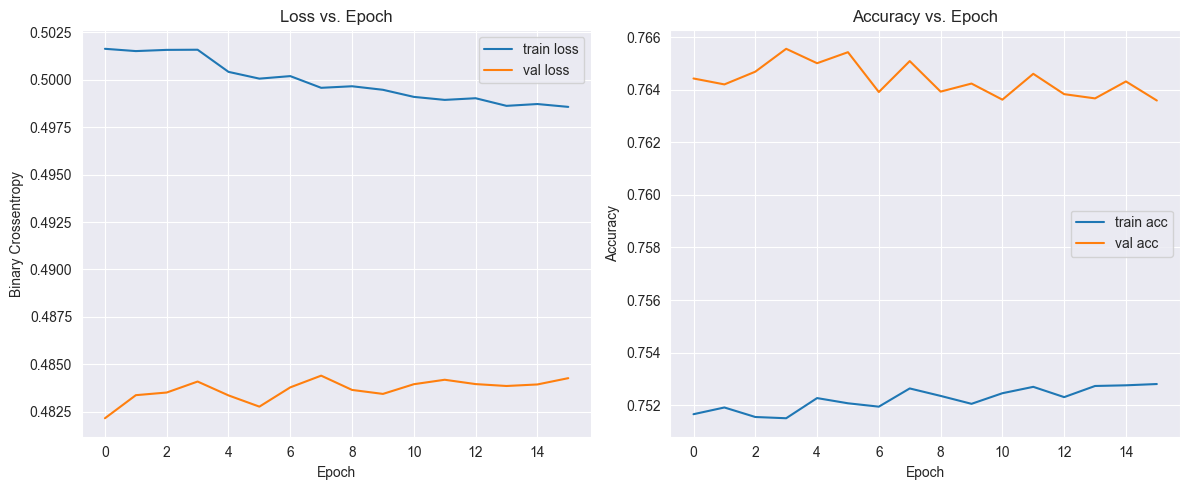

In [31]:
# 8) Plot training history to diagnose under/over‑fitting
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'],   label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'],   label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Da wir eine identische Test Accuracy von 0.765 auf XGBoost bzw. minimal Höher mit dem optimierten RandomForest-Modell erhalten (0.766), verwenden wir weiterhin das RandomForest-Modell 

### Learning Kurve für RandomForest

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   22.4s
[Parallel(n_jo

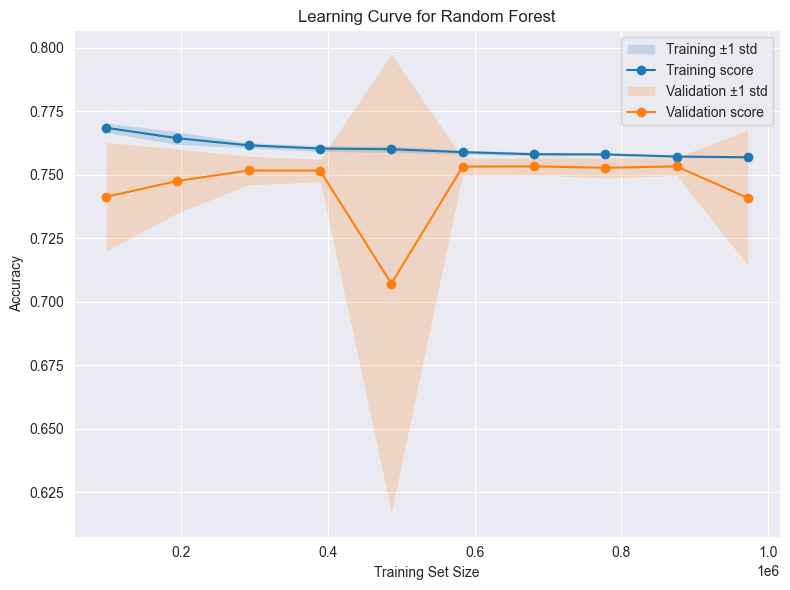

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Compute learning-curve data
train_sizes, train_scores, valid_scores = learning_curve(
    estimator=clf,
    X=X_train,
    y=y_train,
    cv=5,                       # 5-fold CV
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    random_state=42
)

# Calculate means and stds
train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
valid_mean = valid_scores.mean(axis=1)
valid_std  = valid_scores.std(axis=1)

# Plot
plt.figure(figsize=(8,6))
plt.fill_between(train_sizes,
                 train_mean - train_std,
                 train_mean + train_std,
                 alpha=0.2,
                 label='Training ±1 std')
plt.plot(train_sizes, train_mean, 'o-', label='Training score')

plt.fill_between(train_sizes,
                 valid_mean - valid_std,
                 valid_mean + valid_std,
                 alpha=0.2,
                 label='Validation ±1 std')
plt.plot(train_sizes, valid_mean, 'o-', label='Validation score')

plt.title('Learning Curve for Random Forest')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


***

# (6) Main Task B: Probability Prediction of Tips (incl. Log-Loss)
Nutzt weiterhin das RandomForest-Modell 

In [41]:
from sklearn.metrics import log_loss, confusion_matrix, classification_report

# Wahrscheinlichkeiten vorhersagen
y_proba = clf.predict_proba(X_test)[:, 1]

# Log-Loss ausgeben
loss = log_loss(y_test, y_proba)
print(f"Log-Loss: {loss:.4f}")

# Wahrscheinlichkeiten für Klasse "True" (angenommen, Label = 1)
probs = clf.predict_proba(X_test)[:, 1]

# Wahre Labels
y_true = y_test.values

# Individuellen Log-Loss pro Beispiel berechnen
individual_log_loss = -(y_true * np.log(probs) + (1 - y_true) * np.log(1 - probs))

# Ausgabe der ersten 10 Beispiele mit: Index, Wahre Klasse, Vorhergesagte Wahrscheinlichkeit, Log-Loss
print("Index\tTrue Label\tW'keit\t        Log-Loss")
for i in range(10):
      print(f"{i}\t{y_true[i]}\t\t{probs[i]:.4f}\t\t{individual_log_loss[i]:.4f}")

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.1s finished


Log-Loss: 0.4800
Index	True Label	W'keit	        Log-Loss
0	True		0.3636		1.0117
1	False		0.1769		0.1946
2	True		0.7197		0.3289
3	True		0.8857		0.1213
4	False		0.4913		0.6760
5	True		0.6437		0.4405
6	True		0.2760		1.2874
7	False		0.4615		0.6190
8	False		0.1289		0.1380
9	False		0.0822		0.0858


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.1s finished


Interpretation:

- Log-Loss kann theoretisch von 0 (perfekt) bis unendlich gehen.

- Ein komplett zufälliges Modell, das immer 0.5 für beide Klassen vorhersagt, hat einen Log-Loss von etwa 0.693.

- 0.4986 ist also deutlich besser als zufällig, aber nicht „sehr gut“

- Das Modell erreicht 76,6 % Accuracy — das bedeutet, dass etwa 3 von 4 Fällen korrekt klassifiziert werden.

- Der Log-Loss von 0.48 zeigt, dass die Wahrscheinlichkeiten einiger Vorhersagen nicht sehr sicher sind oder teilweise falsch kalibriert (z.B. Wahrscheinlichkeiten nahe 0.5, obwohl die Klasse klar ist).

Es gibt also noch Verbesserungspotenzial bei der Konfidenz der Wahrscheinlichkeiten, auch wenn die Klasse oft richtig getroffen wird.

***

# 7) Preparation of Final Submission (.csv-files) 
Enthält ein Dataframe mit allen Features, die zur Prediction genutzt wurden und den vorhergesagten Werten. Setz das existierende DF zur Generierung der .csv-Dateien neu auf.

In [46]:
#load .csv file
template_df = pd.read_csv("tip25_testdata_template.csv")
template_df.head

<bound method NDFrame.head of        Unnamed: 0  order_id  tip
0              17   2196797  NaN
1              34   1827621  NaN
2              64   2461523  NaN
3             156   2614670  NaN
4             175   3110252  NaN
...           ...       ...  ...
39414     1463304   2078948  NaN
39415     1463309    674892  NaN
39416     1463360    147265  NaN
39417     1463388   1521740  NaN
39418     1463428    243575  NaN

[39419 rows x 3 columns]>

In [42]:
#Create Raw Data Dataset based on transformed dataframe "orders" including all NaN-Values and Last Orders
target_data_prediction = pd.merge(orders, tips, on="order_id", how="left") 
target_data_prediction

,order_id,user_id,order_date,weekday,hour,week-start,is_weekend,nr_previous_orders,days_since_last_order,month-period,Unnamed: 0,tip
0,1374495,3,2024-03-31 14:05:18,Sunday,14,2024-03-25,1,0,0,End,0.0,True
1,444309,3,2024-04-09 19:45:51,Tuesday,19,2024-04-08,0,1,9,Start,1.0,False
2,3002854,3,2024-04-30 16:25:20,Tuesday,16,2024-04-29,0,2,20,End,2.0,False
3,2037211,3,2024-05-20 18:31:28,Monday,18,2024-05-20,0,3,20,Middle,3.0,False
4,2710558,3,2024-06-01 17:52:27,Saturday,17,2024-05-27,1,4,11,Start,4.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
1463627,3059777,206208,2025-02-09 10:08:18,Sunday,10,2025-02-03,1,45,12,Start,1463627.0,True
1463628,2239861,206208,2025-02-18 04:40:09,Tuesday,4,2025-02-17,0,46,8,Middle,1463628.0,True
1463629,1285346,206208,2025-02-23 11:33:43,Sunday,11,2025-02-17,1,47,5,End,1463629.0,True
1463630,1882108,206208,2025-03-02 22:18:46,Sunday,22,2025-02-24,1,48,7,Start,1463630.0,True


In [43]:
# Liste der relevanten aisle_ids
selected_aisles = [62, 134, 28, 124, 27]

# Merge: Verbinde order_products mit products, um die aisle_id zu bekommen
order_products_with_aisles = pd.merge(order_products, products[['product_id', 'aisle_id']], on='product_id', how='left')

# Markiere relevante Aisles
order_products_with_aisles['is_selected_aisle'] = order_products_with_aisles['aisle_id'].isin(selected_aisles).astype(int)

# Aggregiere auf Bestellungsebene: hat die Bestellung mind. ein Produkt in diesen aisles?
has_selected_aisle = (
    order_products_with_aisles
    .groupby('order_id')['is_selected_aisle']
    .max()
    .reset_index()
    .rename(columns={'is_selected_aisle': 'has_selected_aisle'})
)

# Starte mit deinem ursprünglichen Dataset (nur eine Zeile pro Bestellung)
target_data_prediction = pd.merge(orders, tips, on="order_id", how="left")

# Jetzt: Füge nur die berechnete Variable hinzu
target_data_prediction = pd.merge(target_data_prediction, has_selected_aisle, on="order_id", how="left")

# Fehlende Werte (z. B. bei Bestellungen ohne Produkte) mit 0 auffüllen
target_data_prediction['has_selected_aisle'] = target_data_prediction['has_selected_aisle'].fillna(0).astype(int)

target_data_prediction.head()

,order_id,user_id,order_date,weekday,hour,week-start,is_weekend,nr_previous_orders,days_since_last_order,month-period,Unnamed: 0,tip,has_selected_aisle
0,1374495,3,2024-03-31 14:05:18,Sunday,14,2024-03-25,1,0,0,End,0.0,True,0
1,444309,3,2024-04-09 19:45:51,Tuesday,19,2024-04-08,0,1,9,Start,1.0,False,0
2,3002854,3,2024-04-30 16:25:20,Tuesday,16,2024-04-29,0,2,20,End,2.0,False,0
3,2037211,3,2024-05-20 18:31:28,Monday,18,2024-05-20,0,3,20,Middle,3.0,False,0
4,2710558,3,2024-06-01 17:52:27,Saturday,17,2024-05-27,1,4,11,Start,4.0,True,0


In [44]:
# Add all Features we defined for target_data_prediction

#Testing User Tip-Rate (Tipping_History)
target_data_prediction = target_data_prediction.sort_values(["user_id","order_date"]) #Making sure it´s sorted again
target_data_prediction["tipping_history"] = target_data_prediction.groupby("user_id")["tip"].apply(lambda x: x.shift().expanding().mean()).reset_index(level=0, drop=True)
target_data_prediction.head(20)

# Add Month
target_data_prediction['month'] = target_data_prediction['order_date'].dt.month

# Noch Previous und Pre-Previous Tips übernommen (erhalten dadurch NaN-Werte)
target_data_prediction = target_data_prediction.sort_values(['user_id', 'order_date']) # Making sure it´s sorted again

target_data_prediction['previous_tip'] = target_data_prediction.groupby("user_id")['tip'].shift(1)
target_data_prediction['pre_previous_tip'] = target_data_prediction.groupby("user_id")['tip'].shift(2)

# Anzahl vorheriger Tips (total previous tips)
target_data_prediction['tip'] = target_data_prediction['tip'].astype(bool) 
target_data_prediction["total_previous_tips"] = target_data_prediction.groupby("user_id")["tip"].cumsum() - target_data_prediction["tip"] # Tip abziehen, da cumsum kumulative Summe inklusiver aktueller Zeile ist, aber diese Information in Zelle nicht vorliegt (Zeitreihe)

#Kumulative Tipp-Rate-Hour

orders_and_tips = orders_and_tips.sort_values("order_date") # Sortiere nach Zeit, falls noch nicht geschehen

# Berechne kumulative Tipp-Rate je Stunde (ohne Leakage)
target_data_prediction['tip_rate_hour_cum'] = (
    target_data_prediction
    .groupby('hour')['tip']
    .transform(lambda x: x.shift().expanding().mean())
)

# Optional: Ersetze NaNs durch globalen Tipp-Mittelwert
global_tip_mean_target = target_data_prediction['tip'].mean()
target_data_prediction['tip_rate_hour_cum'] = target_data_prediction['tip_rate_hour_cum'].fillna(global_tip_mean_target)

target_data_prediction

,order_id,user_id,order_date,weekday,hour,week-start,is_weekend,nr_previous_orders,days_since_last_order,month-period,Unnamed: 0,tip,has_selected_aisle,tipping_history,month,previous_tip,pre_previous_tip,total_previous_tips,tip_rate_hour_cum
0,1374495,3,2024-03-31 14:05:18,Sunday,14,2024-03-25,1,0,0,End,0.0,True,0,NaN,3,NaN,NaN,0,0.503468
1,444309,3,2024-04-09 19:45:51,Tuesday,19,2024-04-08,0,1,9,Start,1.0,False,0,1.000000,4,True,NaN,1,0.503468
2,3002854,3,2024-04-30 16:25:20,Tuesday,16,2024-04-29,0,2,20,End,2.0,False,0,0.500000,4,False,True,1,0.503468
3,2037211,3,2024-05-20 18:31:28,Monday,18,2024-05-20,0,3,20,Middle,3.0,False,0,0.333333,5,False,False,1,0.503468
4,2710558,3,2024-06-01 17:52:27,Saturday,17,2024-05-27,1,4,11,Start,4.0,True,0,0.250000,6,False,False,1,0.503468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463627,3059777,206208,2025-02-09 10:08:18,Sunday,10,2025-02-03,1,45,12,Start,1463627.0,True,0,0.711111,2,False,True,32,0.497484
1463628,2239861,206208,2025-02-18 04:40:09,Tuesday,4,2025-02-17,0,46,8,Middle,1463628.0,True,0,0.717391,2,True,False,33,0.602178
1463629,1285346,206208,2025-02-23 11:33:43,Sunday,11,2025-02-17,1,47,5,End,1463629.0,True,0,0.723404,2,True,True,34,0.487396
1463630,1882108,206208,2025-03-02 22:18:46,Sunday,22,2025-02-24,1,48,7,Start,1463630.0,True,0,0.729167,3,True,True,35,0.641982


In [47]:
# Filtern: nur die Bestellungen, die auch im vorgegebenen "tip25_testdata_template.csv" Testset vorkommen
target_data_prediction_filtered = target_data_prediction[target_data_prediction["order_id"].isin(template_df["order_id"])].copy()
target_data_prediction_filtered

,order_id,user_id,order_date,weekday,hour,week-start,is_weekend,nr_previous_orders,days_since_last_order,month-period,Unnamed: 0,tip,has_selected_aisle,tipping_history,month,previous_tip,pre_previous_tip,total_previous_tips,tip_rate_hour_cum
17,2196797,5,2024-05-18 11:26:30,Saturday,11,2024-05-13,1,4,5,Middle,NaN,True,0,0.000000,5,False,False,0,0.503468
34,1827621,13,2024-06-29 21:09:43,Saturday,21,2024-06-24,1,12,8,End,NaN,True,0,1.000000,6,True,True,12,1.000000
64,2461523,18,2024-03-08 09:08:45,Friday,9,2024-03-04,0,6,6,Start,NaN,True,0,0.833333,3,True,True,5,0.400000
156,2614670,27,2025-03-20 14:26:50,Thursday,14,2025-03-17,0,81,4,Middle,NaN,True,0,0.098765,3,False,True,8,0.150000
175,3110252,29,2024-08-28 11:10:43,Wednesday,11,2024-08-26,0,18,13,End,NaN,True,0,0.166667,8,False,False,3,0.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463304,2078948,206155,2024-06-18 11:59:24,Tuesday,11,2024-06-17,0,14,14,Middle,NaN,True,1,0.857143,6,True,True,12,0.487393
1463309,674892,206156,2024-05-01 19:00:51,Wednesday,19,2024-04-29,0,4,5,Start,NaN,True,0,0.750000,5,True,True,3,0.613275
1463360,147265,206158,2025-03-09 10:11:36,Sunday,10,2025-03-03,1,50,7,Start,NaN,True,0,0.740000,3,True,True,37,0.497495
1463388,1521740,206165,2024-12-27 00:32:28,Friday,0,2024-12-23,0,27,1,End,NaN,True,0,0.111111,12,False,False,3,0.633782


In [48]:
# Spalten droppen, die wir nicht als Features verwendet haben
target_data_prediction_filtered_cleaned = target_data_prediction_filtered.copy()
columns_to_drop = ['nr_previous_orders', 'days_since_last_order', 'weekday', "week-start", "month-period", "user_id", "order_date", "tip", "Unnamed: 0"]

target_data_prediction_filtered_cleaned = target_data_prediction_filtered_cleaned.drop(columns=columns_to_drop)
target_data_prediction_filtered_cleaned.columns

Index(['order_id', 'hour', 'is_weekend', 'has_selected_aisle',
       'tipping_history', 'month', 'previous_tip', 'pre_previous_tip',
       'total_previous_tips', 'tip_rate_hour_cum'],
      dtype='object')

In [49]:
# data und csv. mergen

# Testdaten mit order_ids aus Vorlage
test_template = template_df.copy()

# Sicherstellen, dass 'order_id' in beiden DataFrames vorhanden ist
assert 'order_id' in test_template.columns
assert 'order_id' in target_data_prediction_filtered_cleaned.columns

# Merge anhand von order_id, um Features zu bekommen
merged_df = test_template.merge(
    target_data_prediction_filtered_cleaned,
    on='order_id',
    how='left'
)

In [50]:
merged_df

,Unnamed: 0,order_id,tip,hour,is_weekend,has_selected_aisle,tipping_history,month,previous_tip,pre_previous_tip,total_previous_tips,tip_rate_hour_cum
0,17,2196797,NaN,11,1,0,0.000000,5,False,False,0,0.503468
1,34,1827621,NaN,21,1,0,1.000000,6,True,True,12,1.000000
2,64,2461523,NaN,9,0,0,0.833333,3,True,True,5,0.400000
3,156,2614670,NaN,14,0,0,0.098765,3,False,True,8,0.150000
4,175,3110252,NaN,11,0,0,0.166667,8,False,False,3,0.300000
...,...,...,...,...,...,...,...,...,...,...,...,...
39414,1463304,2078948,NaN,11,0,1,0.857143,6,True,True,12,0.487393
39415,1463309,674892,NaN,19,0,0,0.750000,5,True,True,3,0.613275
39416,1463360,147265,NaN,10,1,0,0.740000,3,True,True,37,0.497495
39417,1463388,1521740,NaN,0,0,0,0.111111,12,False,False,3,0.633782


In [51]:
# Features, die zum Trainieren verwendet
feature_columns = [
    'hour', 'is_weekend', 'tipping_history', 'month',
    'previous_tip', 'pre_previous_tip', 'tip_rate_hour_cum', 'total_previous_tips', "Unnamed: 0", 'has_selected_aisle'
]

# Sicherstellen, dass keine NaNs vorliegen (ggf. auf Imputing-Strategie zurückgreifen)
X_pred = merged_df[feature_columns]

### Erzeuge .csv Dateien

In [52]:
# Reihenfolge der Features aus dem Training
X_pred = merged_df[X_train.columns]

# Klassifikation (True/False)
merged_df['tip'] = clf.predict(X_pred)

# Nur relevante Spalten exportieren
task_a_output = merged_df[["Unnamed: 0", 'order_id', 'tip']]

# Als CSV speichern
task_a_output.to_csv('Team_2_submission_A.csv', index=False)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.0s finished


In [53]:
# Reihenfolge der Features aus dem Training
X_pred = merged_df[X_train.columns]

# Wahrscheinlichkeiten (nur Spalte für Klasse "True" = 1)
merged_df['tip'] = clf.predict_proba(X_pred)[:, 1]

# Ausgabe
task_b_output = merged_df[["Unnamed: 0", 'order_id', 'tip']]

# Als CSV speichern
task_b_output.to_csv('Team_2_submission_B.csv', index=False)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.0s finished


# 8) Summary

## Task 4a) Prediction der Accuracy

In [54]:
print(f"Train Accuracy: {clf.score(X_train, y_train):.3f}")
print(f"Test Accuracy: {clf.score(X_test, y_test):.3f}")
print(classification_report(y_test, clf.predict(X_test)))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    2.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


Train Accuracy: 0.756


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


Test Accuracy: 0.766
              precision    recall  f1-score   support

       False       0.78      0.80      0.79     34220
        True       0.75      0.72      0.73     27812

    accuracy                           0.77     62032
   macro avg       0.76      0.76      0.76     62032
weighted avg       0.77      0.77      0.77     62032



[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.1s finished


# Task 4b) Prediction des Log-Loss

In [55]:

loss = log_loss(y_test, y_proba)
print(f"Log-Loss: {loss:.4f}")

Log-Loss: 0.4800


## Task 4c & 4d) Liste & Ranking der benutzten Feature

1) **tipping_history (0.54):** kumulierte durchschnittliche Tip-Häufigkeit eines Users (expanding mean) über Bestellungen hinweg
2) **previous_tip (0.44):** binäre Variable, ob in vorheriger Bestellung des Users getippt wurde
3) **pre_previous_tip (0.37):** binäer Variable, ob in vor-voriger Bestellung des Users getiptt wurde
4) **total_previous_tips (0.31):** kumulierte Summe der Tips in den vorigen Bestellungen eines Users
5) **is_weekend(0.16):** binäre Variable zur Klassifizierung des Wochenendes
6) **has_selected_aisle (0.12):** binäre Variable, ob bestimmte aisles in der Bestellung enthalten sind (Aisles 62, 134, 28, 124, 27)
7) **tip_rate_hour_cum (0.11):** kumulierte Tip-Rate je Stunde (Tageszeit)
8) **hour (0.04):** Stunde der Bestellung
9) **month (0.02):** Monat der Bestellung

Die benutzten Features wurden anhand ihrer Korrelationswerte mit der "Tip"-Variable gerankt. Je höher die Korrelation, desto wichtiger die Variable für die Vorhersage der Tips. Dementsprechend ist der Korrelationswert der jeweiligen Variable mit "Tip" hier hinter dem Variablennamen zu finden. <br> <br>
**Hour** und **Month** wurden trotz ihrer Korrelationswerte übernommen, um trotzdem direkt zeitliche Variablen in den Daten enthalten zu haben.

## Task 4e) Liste der unbenutzten Features 

Unbenutzte Features
- nr_previous_orders (-0.01):kumulierte Summe der vorigen Bestellungen eines Users
- days_since_last_order (0.00): Tage seit der letzten Bestellung des Users (erster Wert = 0)
- weekday: Wochentag der Bestellung
- week-start: Startdatum der Woche, in der die Bestellung ist
- month-period: Start, Mitte oder Ende des Monats klassifiziert (Aufteilung des Monats in Drittel)

Diese Features wurden basierend auf ihren niedrigen Korrelationswerten mit der Tip-Variable (s. Angaben in Klammern) nicht in das Modell übernommen. <br>

Das Feature **weekda**y wurde nicht übernommen, da dieselbe Information bereits in der enthaltenen Variable 'is_weekend' enthalten ist. <br> <br>
Die Variable **week-start** als Zeitverlauf ist bereits in allen weiteren Zeitvariablen enthalten und wurde dahe rnicht weiter berücksichtigt. <br> <br>
Da bei der Variable **month-period** kein Zusammenhang in der explorativen Datenanalyse gefunden werden konnte, wurde diese ebenfalls verworfen. 

## Task 4f & 4g) Modelltyp und Hyperparameter

Wir haben zur Modellierung den RandomForestClassifier benutzt, um durch das Nutzen eines Ensemble-Verfahrens und des entsprechenden Baggings möglichst optimale Ergebnisse zu erzielen.

Hierfür wurden folgende Hyperparameter im finalen RandomForestClassifier genutzt:
- n_estimators = 300 
- max_depth = 15
- min_samples_split = 15
- min_samples_leaf = 10
- max_features = 'log2'
- random_state = 42
- n_jobs = -1 

Die Hyperparameter wurden einerseits mit Random Search bestimmt, wobei im Nachgang zusätzlich manuell Trial & Error genutzt wurde, um auf mögliche Veränderungen zu testen. Da sich jedoch keine weitere Verbesserung über die gegebene Accuracy eingestellt hat, wurde es bei den vergebenen Hyperparametern belassen. 

Die Bereiche, die beim Random Search festgelegt wurden, sind folgende (param_dist):
- n_estimators: randint(50,300) - Zufällig zwischen 50 und 299 Bäumen wählen
- max_depth: [NONE] + list(range(10,60,10)) - Keine Begrenzung oder 10, 20, 30, 40, 50
- min_samples_split: randint(2,11) - zufällig zwischen 2 und 10
- min_samples_leaf: randint(1,5) - zufällig zwischen 1 und 4
- max_features("sqrt", "log2") - Auswahl aus zwei festen Optionen 

Hierfür wurden 10 Iterationen mit den entsprechenden Parametern getestet und über ihre Accuracy bewertet. Basierend hierauf sind wir zu den gegeben Hyperparametern gekommen, die unsere Accuracy möglichst maximieren und die Basis für das final genutzte RandomForest-Modell zu nutzen.